# H-star-polynomial
***
***

## Imports

In [1]:
import networkx as nx
import random
import numpy as np
from numpy.linalg import matrix_power
from statistics import mean
import math
import matplotlib.pyplot as plt
import torch
from torch import nn

In [25]:
import julia
from julia.api import Julia
jl = Julia(compiled_modules=False)
from julia import Main
Main.eval('include("helper_funcs.jl")')

<PyCall.jlwrap check_connected>

## Variables

In [17]:
N =10    # Number of vertices in the graph.
M = N*(N-1)//2  # Number of edges in the graph.
punish_value = 100000000
M

45

## Create the neural network

In [18]:
class MYModel(nn.Module):
    def __init__(self, layer_dims):
        super().__init__()

        # Deal with the state and one-hot move vectors separately, since we can do this efficiently.
        self.first_state = nn.Linear(M, layer_dims[0])
        self.first_move = nn.Linear(M, layer_dims[0], bias=False)

        self.layers = nn.ModuleList([
            nn.Linear(a, b)
            for a, b in zip(layer_dims, layer_dims[1:])
        ])

        self.fully_conn = nn.Linear(layer_dims[-1], 1)

    def forward(self, state, move):
        x = self.first_state(state) + self.first_move(move)
        x = nn.functional.relu(x)

        for linear in self.layers:
            x = linear(x)
            x = nn.functional.relu(x)

        x = self.fully_conn(x)
        x = torch.sigmoid(x)
        return x


x = torch.ones((1, M))      # Shape (1, M): the first index is the batch number.
MYModel([10, 10])(x, x)  # Test that we get back something of shape (1, 1).

tensor([[0.4385]], grad_fn=<SigmoidBackward>)

## Utility functions

*Board to adj-matrix and plot/show graph in* **python**:

[[0 0 0 1 0 0 0 1 1 0]
 [0 0 0 1 1 1 1 1 0 0]
 [0 0 0 0 0 0 1 1 0 1]
 [1 1 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 1 1 0 1 0]
 [0 1 0 1 1 0 1 0 0 0]
 [0 1 1 0 1 1 0 0 0 1]
 [1 1 1 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0]]


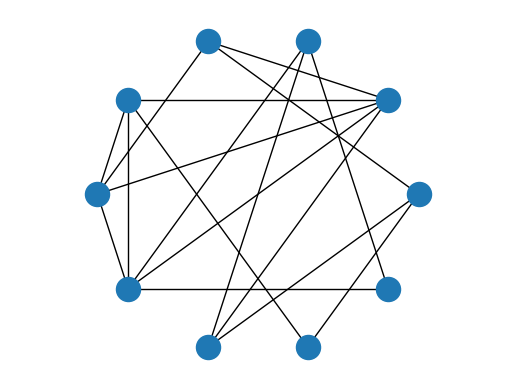

In [19]:
def board_to_adj(board):
    """
    Input: A tensor of shape (*, M), giving a (batched) 01-sequence of edges.
    Output: A tensor of shape (*, N, N), giving a (batched) adjacency matrix.
    """
    adj = np.zeros([*board.shape[:-1], N, N], dtype=np.int8)
    count = 0
    for i in range(N):
        for j in range(i+1, N):
            adj[..., i, j] = adj[..., j, i] = board[..., count] != 0
            count += 1

    return adj


def display_adj(adj):
    print(adj)
    G = nx.convert_matrix.from_numpy_array(adj)
    plt.axis('equal')
    nx.draw_circular(G)
    plt.show()

#Check that it works.
board = np.random.choice([0, 1], size=(M,))
display_adj(board_to_adj(board))

Adj-mat to symmetric edge polytope and computing h-star-polynomial coeffs in **python via julia**:

In [20]:
def from_julia_to_py1(adj):
    if np.sum(adj) == 0:
        return np.zeros((M,))
    else:
        li = Main.symm_edge_polytope_h_star_polynomial_coeff(adj)
        new_li = [Main.Int(x) for x in li]
        return new_li


#board = np.random.choice([0, 1], size=(M,))
board = np.zeros((M,))
adj = board_to_adj(board)
li = from_julia_to_py1(adj)
li

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Adj-mat to cosmological-polytope and computing h-star-polynomial coeffs in **python via julia**:

In [21]:
def from_julia_to_py2(adj):
    if np.sum(adj) == 0:
        return np.zeros((M,))
    else:
        li = Main.cosmological_polytope_h_star_polynomial_coeff(adj)
        new_li = [Main.Int(x) for x in li]

        return new_li

# board = np.random.choice([0, 1], size=(M,))
# adj = board_to_adj(board)
# from_julia_to_py2(adj)

In [22]:
board = np.random.choice([0, 1], size=(M,))
adj = board_to_adj(board)
Main.check_connected(adj)

True

## Generating Games

In [23]:
def play_games(agent, k_games):
    """
    Play k_games using the agent to give probability distributions on each move.
    """

    board = np.zeros((k_games, M), dtype=np.float32)
    moveid = torch.eye(M)

    for step in range(M):
        with torch.no_grad():
          prob = agent(torch.from_numpy(board), moveid[step:step+1, :]).view(k_games).numpy()

        board[:, step] = np.random.rand(k_games) < prob

    return board

# Check that we can generate games from a model.
play_games(MYModel([10, 10]), 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
        0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.]],
      dtype=float32)

## Reinforcing games

In [10]:
def reinforce_games(
    model,
    optimiser,
    games,           # (n_games, M)
    batch_size=90,
):
    """
    Given a list of completed games, reinforce each move in each game.
    """
    n_games, _ = games.shape
    #moveid = torch.eye(M)

    # Unpack the games into (state, move, actions).
    states = torch.zeros((n_games, M, M))
    moveids = torch.zeros((n_games, M, M))
    actions = torch.zeros((n_games, M, 1))
    for t in range(M):
        moveids[:, t, t] = 1
        states[:, t+1:, t] = torch.from_numpy(games[:, None, t])
        actions[:, t, 0] = torch.from_numpy(games[:, t])

    # Reshape these so that we can shuffle the moves between games.
    states = states.flatten(end_dim=1)
    moveids = moveids.flatten(end_dim=1)
    actions = actions.flatten(end_dim=1)

    # Reinforce
    criterion = nn.BCELoss()
    shuffle = torch.randperm(n_games * M)
    for i in range(0, n_games * M, batch_size):
        batch = shuffle[i:i+batch_size]

        optimiser.zero_grad()
        predicted = model(states[batch], moveids[batch])
        loss = criterion(predicted, actions[batch])
        loss.backward()
        optimiser.step()


# Check that this works.
model = MYModel([10, 10])
reinforce_games(
    model=model,
    optimiser=torch.optim.SGD(model.parameters(), lr=0.01),
    games=play_games(model, 2),
)

## Score Function and Hyperparameter's

In [26]:
# Number of new games to play each round.
K_GAMES = 100

# Create a fresh network, and specify its architecture.
model = MYModel([32, 12, 4])

# The learning rate should be increased if convergence is too slow, but decreased if
# the algorithm keeps getting stuck in local minima.
optimiser = torch.optim.Adam(model.parameters(), lr=0.0009)

# The percentage of K_GAMES to reinforce.
KEEP_TOP = round(K_GAMES * 0.05)

# The scoring function to use
def score_fn(adj,choice):

    # Check if graph is connected
    conn = Main.check_connected(adj)
    
    if conn == False:
        return punish_value
    else:
        if choice == "symm":
            l = list(from_julia_to_py1(adj))
        elif choice == "cosmo":
            l = list(from_julia_to_py2(adj))

        if np.sum(l)==0:
            return punish_value
        else:

            max_pos = l.index(max(l))

            diff_vec = []
            for i in range(max_pos+1,len(l)):
                if i != len(l)-1:
                    diff = l[i]-l[i+1]
                    diff_vec.append(diff)
            
            if diff_vec !=[]:
                return min(diff_vec)
            else:
                return punish_value

board = np.random.choice([0, 1], size=(M,))
adj = board_to_adj(board)
score_fn(adj,"symm")

50

In [27]:
games1 = play_games(MYModel([10, 2, 10]),20)
games2 = np.zeros((0, M), dtype=np.float32)
games = np.concatenate([games1, games2], axis=0)

for game in games:
    adj = board_to_adj(game)
    print(adj)
    score = score_fn(adj,"symm")
    print(score)

[[0 1 0 0 0 0 1 0 1 1]
 [1 0 1 1 0 0 0 0 0 0]
 [0 1 0 1 1 1 0 0 0 1]
 [0 1 1 0 1 0 1 1 0 1]
 [0 0 1 1 0 0 1 0 1 0]
 [0 0 1 0 0 0 1 0 1 1]
 [1 0 0 1 1 1 0 0 0 1]
 [0 0 0 1 0 0 0 0 1 1]
 [1 0 0 0 1 1 0 1 0 0]
 [1 0 1 1 0 1 1 1 0 0]]
34
[[0 0 0 1 0 1 1 0 0 1]
 [0 0 0 1 0 0 1 0 0 0]
 [0 0 0 1 0 1 0 1 0 0]
 [1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 1 0]
 [1 0 1 0 1 0 1 0 0 1]
 [1 1 0 0 0 1 0 1 0 0]
 [0 0 1 0 1 0 1 0 0 1]
 [0 0 0 0 1 0 0 0 0 1]
 [1 0 0 0 0 1 0 1 1 0]]
24
[[0 1 0 0 0 0 1 0 1 1]
 [1 0 0 1 0 1 0 1 0 0]
 [0 0 0 0 1 1 1 0 1 0]
 [0 1 0 0 1 0 0 1 1 0]
 [0 0 1 1 0 0 0 1 0 0]
 [0 1 1 0 0 0 0 0 1 0]
 [1 0 1 0 0 0 0 1 0 0]
 [0 1 0 1 1 0 1 0 0 1]
 [1 0 1 1 0 1 0 0 0 1]
 [1 0 0 0 0 0 0 1 1 0]]
28
[[0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 1 1 0]
 [0 1 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 1 1]
 [0 0 0 0 1 0 0 0 0 0]
 [1 1 0 0 1 0 1 0 0 0]
 [0 1 0 1 0 1 1 0 0 0]]
100000000
[[0 0 0 1 0 0 1 0 1 1]
 [0 0 0 0 1 0 0 1 1 0]
 [0 0 0 1 1

In [ ]:
# This cell can be re-run without resetting the model.

# Keep only the top so many games here.
top_games = np.ones((0, M), dtype=np.float32)

for i in range(51):
    # Play some new games.
    new_games = play_games(model, K_GAMES)

    # Mix these games into our pot of the best games so far.
    games = np.concatenate([top_games, new_games], axis=0)

    # Score the games, and rearrange into descending order by score.
    scores = []
    for game in games:
        adj = board_to_adj(game)
        score = score_fn(adj,"symm")
        scores.append(score)
    
    scores = np.array(scores)
    order = np.argsort(scores)[:KEEP_TOP]
    top_games = games[order]
    
    # Train
    reinforce_games(model, optimiser, top_games, batch_size=90)

    # Display progress
    if i % 5 == 0:
        top_adj = board_to_adj(top_games[:3])
        print(i)
        for game in top_adj:
            print(f"Scores: {score_fn(game,'symm')}")
            print(f"Coeff's: {from_julia_to_py2(game)}")

        display_adj(board_to_adj(top_games[0]))
